# Network utility functions

In [1]:
%load_ext autoreload
%autoreload 2

import os
import shutil
import numpy as np
from src.spiking_network.network.neuvisys import (
    SpikingNetwork,
    clean_network,
    shuffle_weights,
)
from src.spiking_network.network.network_params import (
    inhibition_learning_params,
    inhibition_disparity_params,
)
from src.events.tools.read_write.aedat_tools import (
    load_aedat4,
)
from src.events.tools.read_write.events_tools import (
    write_npz,
    npaedat_to_np,
    ros_to_npy,
)
from src.events.tools.modification.event_modification import (
    show_event_images,
    rectify_events,
    remove_events,
    concatenate_npz,
)
from src.events.tools.generation.stimuli_gen import (
    moving_bars,
    moving_lines,
    disparity_bars
)
from src.events.tools.generation.pix2nvs import Pix2Eve
from src.frames.frame_analysis import (
    load_frames,
    rectify_frames,
    write_frames,
    stereo_matching,
)
from src.spiking_network.planning.network_planner import (
    create_networks,
    random_params,
    launch_neuvisys_multi_pass,
    change_param,
    divide_visual_field,
)

os.chdir("/home/thomas/neuvisys-analysis/src")
home = "/home/thomas/"

# network_path = home + "neuvisys-dv/configuration/network_ref_vh/"
network_path = home + "Desktop/Experiment/network_0/"

## CAUTION: Delete Weights

In [41]:
clean_network("/home/thomas/Desktop/Experiment/network_0/", [0, 1])

## Network creation and launch

In [5]:
# params = {"simple_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}, "complex_cell_config" : {"ETA_LTP": [0.0077, 0.0077]}}
# create_networks(home + "neuvisys-dv/cmake-build-release", home + "Bureau", 2, {})
random_params("/home/thomas/neuvisys-dv/cmake-build-release", "/home/thomas/Desktop/Experiment", 1)

In [ ]:
# Launch training of multiple networks

n_networks = 100
exec_path = home + "neuvisys-dv/build/neuvisys-exe"
networks_path = home + "Desktop/test/"
event_path = home + "Desktop/shapes.npz"

params = {"simple_cell_config": {"TARGET_SPIKE_RATE": [0.1, 0.2, 0.3]}}

create_networks(exec_path, networks_path, n_networks, params)
nb_iterations = 5

df = []

for i in range(0, n_networks):
    launch_neuvisys_multi_pass(
        exec_path, networks_path + "network_" + str(i) + "/configs/network_config.json", event_path, nb_iterations,
    )

    spinet = SpikingNetwork(networks_path + "network_" + str(i) + "/")
    # display_network([spinet], 0)
    # update_dataframe(df, spinet)

# df = pd.DataFrame(df)
# df.to_csv(home + "Desktop/test/df")

#### Orientation response

In [7]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
network_path = home + "Desktop/network_experiment/"
event_rotation = home + "Videos/lines/rotations/"

spikes = [[], []]
rotations = np.array([0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338])
for rot in rotations:
    launch_neuvisys_multi_pass(exec_path, network_path + "configs/network_config.json",
                               event_rotation + str(rot) + ".npz", 5)
    spinet = SpikingNetwork(network_path)
    spikes[0].append(spinet.spikes[0])
    spikes[1].append(spinet.spikes[1])
spinet.save_complex_directions(spikes[1], rotations)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
50%
Saving Network...
Creating network state file
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
50%
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
50%
Saving Network...
Finished.
Layer 0: wei

#### Inhibition weight learning

In [59]:
exec_path = home + "neuvisys-dv/cmake-build-release/neuvisys-exe"
networks_path = home + "Desktop/Experiment/"
event_path = home + "Videos/disparity/"

shapes = home + "Videos/shapes.npz"
h_events = home + "Videos/lines/hlines.npz"
v_events = home + "Videos/lines/vlines.npz"
vh_events = home + "Videos/lines/vhlines.npz"
rot_events = home + "Videos/lines/rotations.npz"

events_0and4 = home + "Videos/disparity/0&4_disp.npz"
events_0 = home + "Videos/disparity/0_disp.npz"
events_4 = home + "Videos/disparity/4_disp.npz"

ref = event_path + "full_disparity.npz"
events = {0: event_path + "0_disp.npz",
          1: event_path + "4_disp.npz"}

list_events_rot = []
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    list_events_rot.append(home + "Videos/lines/rotations/" + str(rotation) + ".npz")

In [22]:
# params = inhibition_learning_params({'network_config': {'layerPatches': [[[20], [20], [0]], [[0], [0], [0]]],
#                                                         'layerSizes': [[16, 16, 144], [4, 4, 16]],
#                                                         'neuronSizes': [[10, 10, 1], [4, 4, 144]], }
#                                      })
params = inhibition_disparity_params()
create_networks(exec_path, networks_path, 1, params)

##### learning the base network

In [23]:
## learning the base network
path = networks_path + "network_0/"

# draw = np.random.randint(0, 2, size=30)
# for ind in draw:
#     launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", events[ind], 1)

for i in range(10):
    if i % 2:
        launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", events_4, 1)
    else:
        launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", events_0, 1)

# launch_neuvisys_multi_pass(exec_path, path + "configs/network_config.json", shapes, 5)

Layer 0: new weights generated
Layer 1: new weights generated
Unpacking events...
Saving Network...
Creating network state file
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
Saving Network...
Finished.
Layer 0: weights loaded from file
Layer 1: weights

##### learning inhibition weights

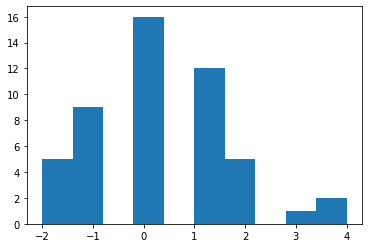

In [60]:
## learning inhibition weights

from scipy.stats import expon, laplace
import matplotlib.pyplot as plt

# draw = expon(0, 1).rvs(size=30)
draw = laplace(0, 1).rvs(size=50)
draw = np.round(draw)

plt.hist(draw)

shutil.copytree(path, networks_path + "network_inhibition")
change_param(networks_path + "network_inhibition/configs/simple_cell_config.json", "STDP_LEARNING", "inhibitory")
change_param(networks_path + "network_inhibition/configs/complex_cell_config.json", "STDP_LEARNING", "none")

In [62]:
launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", events_0, 20)

# for ind in draw:
#     launch_neuvisys_multi_pass(exec_path, networks_path + "network_inhibition/configs/network_config.json", list_events_rot[int(ind)], 1)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
12%
25%
37%
50%
62%
75%
88%
Saving Network...
Finished.


In [63]:
shutil.copytree(networks_path + "network_inhibition", networks_path + "network_control")
shutil.copytree(networks_path + "network_inhibition", networks_path + "network_experiment")

change_param(networks_path + "network_control/configs/simple_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_control/configs/complex_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_experiment/configs/simple_cell_config.json", "STDP_LEARNING", "none")
change_param(networks_path + "network_experiment/configs/complex_cell_config.json", "STDP_LEARNING", "none")

##### experiment

In [64]:
launch_neuvisys_multi_pass(exec_path, networks_path + "network_experiment/configs/network_config.json", events_0and4, 5)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
25%
50%
75%
Saving Network...
Finished.


##### control test

In [65]:
shuffle_weights(networks_path + "network_control/weights/0/")
launch_neuvisys_multi_pass(exec_path, networks_path + "network_control/configs/network_config.json", events_0and4, 5)

Layer 0: weights loaded from file
Layer 1: weights loaded from file
Unpacking events...
25%
50%
75%
Saving Network...
Finished.


## Event manipulation:
Functions for loading, writing or creating event files in the different formats (aedat4, npz, rosbag...)

In [114]:
# Load events
events = load_aedat4(home + "Desktop/shape_hovering_fast.aedat4")

In [33]:
list_events = [np.load("/home/thomas/Videos/disparity/0_disp.npz"), np.load("/home/thomas/Videos/disparity/4_disp.npz")]
concat_events = concatenate_npz(list_events)

(18283200, 8)

In [58]:
# Save aedat file as numpy npz file
# write_npz(home + "Desktop/shape_hovering_fast", events)  # mono
# write_npz(home + "Desktop/shapes", (left_events, right_events)) # stereo

left_events = np.load("/home/thomas/Videos/disparity/left.npz")
right_events = np.load("/home/thomas/Videos/disparity/right.npz")
write_npz("/home/thomas/Videos/disparity/0&4_disp", (left_events, right_events))

In [ ]:
# Load rosbag and convert it to npdat
left_events = ros_to_npy(home + "Downloads/outdoor_night1_data.bag", topic="/davis/left/events")
right_events = ros_to_npy(home + "Downloads/outdoor_night1_data.bag", topic="/davis/right/events")

In [ ]:
# Rectify and plot event images
rect_events = rectify_events((events[0].copy(), events[1].copy()), -5, -16, 5, 16)

for i in range(2):
    show_event_images(
        npaedat_to_np(rect_events[0]),
        100000,
        346,
        260,
        "/media/alphat/DisqueDur/0_Thesis/short_pavin2_img/",
        ([10, 84, 158, 232, 306], [20, 83, 146, 209]),
        "_" + str(i),
    )

In [ ]:
# remove events from specific intervals
tss = [
    1615820915344885,
    1615820923944885,
    1615820925444885,
    1615820944844885,
    1615820947944885,
]
tse = [
    1615820916544885,
    1615820924344885,
    1615820925544885,
    1615820945244885,
    1615820948144885,
]

l_events, r_events = remove_events(rect_events, tss, tse)

In [8]:
list_events = []
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    list_events.append(np.load("/home/thomas/Videos/lines/rotations/" + str(rotation) + ".npz"))
events = concatenate_npz(list_events)

In [10]:
write_npz("/home/thomas/Videos/rotations", events)

## Frame manipulation

In [ ]:
frames = load_frames("/media/alphat/DisqueDur/0_Thesis/pavin.aedat4")

In [ ]:
rect_frames = rectify_frames(frames, -4, 8, 4, -8)

write_frames(
    "/home/alphat/Desktop/im1/", rect_frames, ([10, 84, 158, 232, 306], [20, 83, 146, 209]),
)

In [ ]:
# Stereo matching
disp_frames, disp_nb_frames = stereo_matching(
    "/home/alphat/Desktop/pavin_images/im1/", [10, 84, 158, 232], [20, 83, 146], range(0, 200),
)

## Create event videos

Generate frames of the desired visual stimuli, then convert those frames into an event stream

In [55]:
framerate = 1000
time_gap = 1e6 * 1 / framerate
folder = home + "Desktop/Events/right/"

In [ ]:
disparity_bars(folder, disparities=[0, 0, 0, 0], framerate=framerate)
disparity_bars(folder, disparities=[8, 6, 4, 2], framerate=framerate)

In [21]:
for rotation in [0, 23, 45, 68, 90, 113, 135, 158, 180, 203, 225, 248, 270, 293, 315, 338]:
    os.mkdir(folder + str(rotation) + "/")
    moving_lines(folder + str(rotation) + "/", time=2, rotation=rotation, framerate=framerate)

In [56]:
moving_lines(folder, time=2, framerate=framerate, rotation=0, disparity=0, frame_start=0)
moving_lines(folder, time=2, framerate=framerate, rotation=0, disparity=4, frame_start=2000)

In [57]:
print("Converting frames to event -> " + folder)
pix2eve = Pix2Eve(
    folder,
    time_gap=time_gap,
    log_threshold=0,
    map_threshold=0.4,
    n_max=5,
    adapt_thresh_coef_shift=0.05,
)
events = pix2eve.run()
events = events[events[:, 0].argsort()]
write_npz(home + "Videos/disparity/right", events)

Converting frames to event -> /home/thomas/Desktop/Events/right/
0.0%...
5.0%...
10.0%...
15.0%...
20.0%...
25.0%...
30.0%...
35.0%...
40.0%...
45.0%...
50.0%...
55.0%...
60.0%...
65.0%...
70.0%...
75.0%...
80.0%...
85.0%...
90.0%...
95.0%...
Finished conversion


## Divide visual field

In [ ]:
X, Y = divide_visual_field(5, 1, 40, 40)